# Stock market prediction

The stock market is known for being volatile, dynamic, and nonlinear. Accurate stock price prediction is extremely challenging because of multiple (macro and micro) factors, such as politics, global economic conditions, unexpected events, a company’s financial performance, and so on. 

But, all of this also means that there’s a lot of data to find patterns in. So, financial analysts, researchers, and data scientists keep exploring analytics techniques to detect stock market trends. This gave rise to the concept of `algorithmic trading`, which uses automated, pre-programmed trading strategies to execute orders.

<img src="http://prod-upp-image-read.ft.com/8b349314-3b8d-11e7-ac89-b01cc67cfeec" width="700"/>


* Fundamental analysis
* Technical analysis 
    * Analyzes measurable data from stock market activities, such as stock prices, historical returns, and volume of historical trades; i.e. quantitative information that could identify trading signals and capture the movement patterns of the stock market. 
    * Technical analysis focuses on historical data and current data just like fundamental analysis, but it’s mainly used for short-term trading purposes.
    * Due to its short-term nature, technical analysis results are easily influenced by news.
Popular technical analysis methodologies include moving average (MA), support and resistance levels, as well as trend lines and channels. 

In [58]:
import re
import json
import requests
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os
import datetime
import jdatetime
import locale
jdatetime.set_locale('fa_IR')
from persiantools.jdatetime import JalaliDate

import time
import statistics
import json
from persiantools.jdatetime import JalaliDate
import datetime 
def convert_ar_characters(input_str):

    mapping = {
        'ك': 'ک',
        'دِ': 'د',
        'بِ': 'ب',
        'زِ': 'ز',
        'ذِ': 'ذ',
        'شِ': 'ش',
        'سِ': 'س',
        'ى': 'ی',
        'ي': 'ی'
    }
    return _multiple_replace(mapping, input_str)
def _multiple_replace(mapping, text):
    pattern = "|".join(map(re.escape, mapping.keys()))
    return re.sub(pattern, lambda m: mapping[m.group()], str(text))

import plotly.express as px
import plotly.graph_objects as go

## MarketData


* Included Data from all the tickers in the Tehran Market Data(`MarketWatchPlus` in TSE)
* descriptive fields: 
    * `ID`, `ISIN`, `symbol`, `full-name`
* trades information
    * first_price, close_price, last_price , min , max, return , last_return
    * volume, value 
* orderbook:
    * bid price : The bid price refers to the `highest` price a buyer will pay for a security
    * ask price : The ask price refers to the `lowest` price a seller will accept for a security.
<img src='https://www.projectfinance.com/wp-content/uploads/2022/01/bid-mid-ask.png'>

In [2]:

def getTodayData_allTickers():

    url = 'http://www.tsetmc.com/tsev2/data/MarketWatchPlus.aspx?h=0&r=0'
    data = requests.get(url, timeout=12)
    content = data.content.decode('utf-8')
    parts = content.split('@')
    inst_price = parts[2].split(';')
    marketdict = {}
    # Add the Trade and other stuff to dataframe--------
    for item in inst_price:
        item=item.split(',')
        marketdict[item[0]]= dict(id=item[0],ISIN=item[1],symbol=item[2],
                              name=item[3],first_price=float(item[5]),close_price=float(item[6]),
                              last_trade=float(item[7]),count=item[8],volume=float(item[9]),
                              value=float(item[10]),min_traded_price=float(item[11]),
                              max_treaded_price=float(item[12]),yesterday_price=int(item[13]),
                              table_id=item[17],group_id=item[18],max_allowed_price=float(item[19]),
                              min_allowed_price=float(item[20]),ret_last = (float(item[7]) - float(item[13]))/float(item[13]),
                                 ret_close = (float(item[6]) - float(item[13]))/float(item[13]),
                                number_of_shares=float(item[21]), Market_cap=int(item[21]) *int(item[6]))
    # Add the Ask-Bid price Vol tu dataframe --------
    for item in parts[3].split(';'):
        try:
            item=item.split(',')

            marketdict[item[0]]['bid_price{}'.format(item[1])]=  float(item[4])
            marketdict[item[0]]['bid_vol{}'.format(item[1])]=  float(item[6])
            
            marketdict[item[0]]['ask_price{}'.format(item[1])]=  float(item[5])
            marketdict[item[0]]['ask_vol{}'.format(item[1])]=  float(item[7])

        except:
            pass
    df = pd.DataFrame(marketdict ).T
    df['name'] = df['name'].apply(convert_ar_characters)
    df = df[df['symbol'].map(lambda x: x.isalpha())]
    df = df[~df['ISIN'].str.startswith('IRT') & ~df['ISIN'].str.startswith('IRR')]
    
    
    return df.reset_index(drop=True)

In [69]:
df = getTodayData_allTickers()

In [70]:
df

id          ISIN symbol                          name  \
0      114312662654155  IRO3SAIZ0001  وسپهر  سرمایه گذاری مالی سپهرصادرات   
1      204092872752957  IRO3SDFZ0001   شصدف                صنعتی دوده فام   
2      318005355896147  IRO7PFSP0001    فسا                  پتروشیمی فسا   
3      408934423224097  IRO1FRVR0001  فرآور       فرآوری‌موادمعدنی‌ایران‌   
4      611986653700161  IRO3SBZZ0001  سبزوا              سیمان لار سبزوار   
..                 ...           ...    ...                           ...   
610  71744682148776880  IRO1LSMD0001  ولصنم            لیزینگ‌صنعت‌ومعدن‌   
611  71758511001096824  IRO3MINZ0001  غصينو                    صنعتی مینو   
612  71856634742001725  IRO1SEPK0001     سپ    پرداخت الکترونیک سامان کیش   
613  71957984642204570  IRO7APTP0001  شپترو               پتروشیمی آبادان   
614  72044846109864381  IRO3ARTZ0001  پارتا      مجتمع صنعتی آرتاویل تایر   

    first_price close_price last_trade count      volume           value  ...  \
0        6870.0      6850.0     6850.0   744   1863915.0   12775699370.0  ...   
1       32600.0     33300.0    33350.0   505    536059.0   17846145850.0  ...   
2         791.0       814.0      797.0   181   3093881.0    2506608930.0  ...   
3       23220.0     23580.0    23520.0   226    292421.0    6904592000.0  ...   
4        3330.0      3284.0     3256.0  2085  40088199.0  131658354128.0  ...   
..          ...         ...        ...   ...         ...             ...  ...   
610      2776.0      2701.0     2716.0   498   2246387.0    6052994907.0  ...   
611      9290.0      9340.0     9360.0   526   2542860.0   23884693540.0  ...   
612     24820.0     25680.0    24970.0   186    141094.0    3505704460.0  ...   
613      1656.0      1653.0     1656.0   162   5788323.0    9582553086.0  ...   
614      6790.0      7000.0     6800.0   185    882776.0    6021722710.0  ...   

    ask_price3  ask_vol3 bid_price4  bid_vol4 ask_price4 ask_vol4 bid_price5  \
0       6880.0    1100.0     6740.0    1055.0     6900.0  45466.0     6700.0   
1      33750.0     156.0    33050.0    9020.0    33800.0  11969.0    33000.0   
2        815.0    6590.0        0.0       0.0      817.0  10000.0        0.0   
3      23700.0    2537.0    23460.0    4135.0    23760.0     50.0    23450.0   
4       3337.0  222000.0     3226.0  354028.0     3338.0  61932.0     3225.0   
..         ...       ...        ...       ...        ...      ...        ...   
610     2722.0    5226.0     2711.0    1500.0     2725.0   7382.0     2710.0   
611     9420.0    1613.0     9320.0   12638.0     9430.0   8305.0     9310.0   
612    25000.0    1896.0    24570.0     250.0    25020.0    831.0    24560.0   
613     1860.0   10000.0     1608.0   44394.0     1870.0   4697.0     1600.0   
614     6920.0    1000.0        0.0       0.0     6930.0    745.0        0.0   

    bid_vol5 ask_price5   ask_vol5  
0     2749.0     6910.0     4135.0  
1     1619.0    33850.0       21.0  
2        0.0      818.0    15000.0  
3      304.0    23780.0       20.0  
4    47865.0     3339.0  2452197.0  
..       ...        ...        ...  
610   1000.0     2726.0     2002.0  
611   7438.0     9440.0    50000.0  
612    250.0    25030.0     1000.0  
613  35000.0     1875.0     9000.0  
614      0.0     6940.0     7205.0  

[615 rows x 41 columns]

In [61]:

df.columns

Index(['id', 'ISIN', 'symbol', 'name', 'first_price', 'close_price',
       'last_trade', 'count', 'volume', 'value', 'min_traded_price',
       'max_treaded_price', 'yesterday_price', 'table_id', 'group_id',
       'max_allowed_price', 'min_allowed_price', 'ret_last', 'ret_close',
       'number_of_shares', 'Market_cap', 'bid_price1', 'bid_vol1',
       'ask_price1', 'ask_vol1', 'bid_price2', 'bid_vol2', 'ask_price2',
       'ask_vol2', 'bid_price3', 'bid_vol3', 'ask_price3', 'ask_vol3',
       'bid_price4', 'bid_vol4', 'ask_price4', 'ask_vol4', 'bid_price5',
       'bid_vol5', 'ask_price5', 'ask_vol5'],
      dtype='object')

In [62]:
def getTodayClientData_allTickers():
    url = 'http://www.tsetmc.com/tsev2/data/ClientTypeAll.aspx'
    data = requests.get(url, timeout=15)
    content=data.content.decode('utf-8').split(";")

    clienttype=[]
    for item in content:
        try:
            item=item.split(',')
            clienttype.append(dict( id=item[0],
                                        Individual_buy_count=int(item[1]),
                                            NonIndividual_buy_count=int(item[2]),
                                            Individual_buy_volume=int(item[3]),
                                            NonIndividual_buy_volume=int( item[4]) ,
                                            Individual_sell_count=int(item[5]),
                                            NonIndividual_sell_count=int(item[6]),
                                            Individual_sell_volume=int(item[7]),
                                            NonIndividual_sell_volume=int(item[8]), 
                                            proportion_buy_ind = int(item[3]) /(int(item[3]) + int(item[4]) ),
                                            proportion_sell_ind = int(item[7]) /(int(item[7]) + int(item[8]) )))
        except:pass

    clients = pd.DataFrame(clienttype)


    return clients 

In [71]:
cl = getTodayClientData_allTickers()
cl

id  Individual_buy_count  NonIndividual_buy_count  \
0     1775538989481366                    17                        0   
1    62163307327505842                    32                        0   
2    18668624820225527                    15                        0   
3    69685517156367976                    20                        0   
4     4300391363245682                     0                        1   
..                 ...                   ...                      ...   
971  47377315952751604                    21                        1   
972  47749661205825616                    19                        1   
973   4758266259250794                    41                        0   
974  41935584690956944                   171                        1   
975  67690708346979840                   124                        2   

     Individual_buy_volume  NonIndividual_buy_volume  Individual_sell_count  \
0                      700                         0                     63   
1                     2802                         0                    107   
2                      930                         0                     75   
3                     1137                         0                     90   
4                        0                      1000                      0   
..                     ...                       ...                    ...   
971                  29715                     66668                     10   
972                 112393                     18528                     19   
973                 573157                         0                     73   
974                8605986                   2481564                    160   
975                9322332                    155225                    237   

     NonIndividual_sell_count  Individual_sell_volume  \
0                           0                     700   
1                           0                    2802   
2                           0                     930   
3                           0                    1137   
4                           1                       0   
..                        ...                     ...   
971                         0                   96383   
972                         0                  130921   
973                         0                  573157   
974                         0                11087550   
975                         1                 7911879   

     NonIndividual_sell_volume  proportion_buy_ind  proportion_sell_ind  
0                            0            1.000000             1.000000  
1                            0            1.000000             1.000000  
2                            0            1.000000             1.000000  
3                            0            1.000000             1.000000  
4                         1000            0.000000             0.000000  
..                         ...                 ...                  ...  
971                          0            0.308301             1.000000  
972                          0            0.858480             1.000000  
973                          0            1.000000             1.000000  
974                          0            0.776185             1.000000  
975                    1565678            0.983622             0.834802  

[976 rows x 11 columns]

In [72]:
df= pd.merge(df, cl ,on='id',how='left')

# df = pd.read_csv('./August03_2022_TSE.csv').drop('Unnamed: 0',axis=1)
# df

In [73]:
df['valueBuy_ind'] = df['proportion_buy_ind'] * df['value']
df['valueSell_ind'] = df['proportion_sell_ind'] * df['value']


In [74]:
df['percapitaBuy_ind'] = df['valueBuy_ind']  / df['Individual_buy_count']
df['percapitaSell_ind'] = df['valueSell_ind']  / df['Individual_sell_count']


In [76]:
df.loc[df['percapitaSell_ind'] == 0 ,'percapitaSell_ind'] = 1e-6

df['powerRatio_ind'] = df['percapitaBuy_ind']/df['percapitaSell_ind']


### make some plots

In [79]:
px.scatter(df.sort_values('percapitaBuy_ind', ascending=False),
           x='symbol' , y='percapitaBuy_ind', log_y=True, 
           labels={'percapitaBuy_ind' :'percapitaBuy_ind(Rials)'})

In [82]:
px.scatter(df.sort_values('value', ascending=False),
           x='symbol' , y='value', log_y=True)

In [83]:
fig=px.scatter(df,
           x='symbol' , y=df['value']/df['Market_cap'])

hline_value = np.quantile(df['value']/df['Market_cap'],.9)

fig.add_hline(y=hline_value , line_width=3, line_dash="dash", line_color="green")
fig.show()

#### Data of Tehran Stock market index
* The TEDPIX is a major stock market index which tracks the performance of the major companies listed on the Tehran Stock Exchange.

In [84]:
def main_index():
    
    url='http://www.tsetmc.com/tsev2/chart/data/Index.aspx?i=32097828799138957&t=value'
    data=requests.get(url, timeout=10)
    content= data.content.decode('utf-8').split(';')
    dates = [  JalaliDate(int(content[i].split(',')[0].split('/')[0]),
                         int(content[i].split(',')[0].split('/')[1]), 
                         int(content[i].split(',')[0].split('/')[2])).to_gregorian()   for i in range(len(content))]
    dates_2 = pd.to_datetime(dates)

    indexx = [float(content[i].split(',')[1]) for i in range(len(content))]
    df = pd.DataFrame(indexx, dates_2, columns=['IRX'])
    df.reset_index(inplace=True)
    df.columns= ['date' , 'IRX']
    return df


In [85]:
main_index()

date        IRX
0    2008-12-04     9248.9
1    2008-12-05     9248.9
2    2008-12-06     9178.3
3    2008-12-07     9130.5
4    2008-12-08     9089.2
...         ...        ...
3295 2022-07-30  1440855.3
3296 2022-07-31  1423496.7
3297 2022-08-01  1427605.6
3298 2022-08-02  1430021.0
3299 2022-08-03  1437360.8

[3300 rows x 2 columns]

In [86]:
dollar=pd.read_csv('./USDIRT_Daily_200905030000_202208020000.csv')
dollar['date'] = pd.to_datetime(dollar['date'])

In [89]:
fig=px.line(y=dollar['close'], x=dollar['date'] ,
            labels={'y': 'dollar price' , 'x':'date'}, log_y=True)
fig.show()

In [90]:
main_index= main_index()

In [94]:
IRX_toDollar = pd.merge(main_index, dollar)

In [96]:
IRX_toDollar

date        IRX   open   high    low  close    vol  spread
0    2009-05-03     8584.6    988    988    988    988    100       0
1    2009-05-10     8930.4    985    985    985    985    600       0
2    2009-05-17     8919.4    989    989    989    989    600       0
3    2009-05-24     9019.5    973    973    973    973    500       0
4    2009-05-31     9000.6    968    968    968    968    500       0
...         ...        ...    ...    ...    ...    ...    ...     ...
2065 2022-07-27  1443712.6  31854  31930  31848  31874  69063      26
2066 2022-07-30  1440855.3  31877  31957  31863  31916  67516      26
2067 2022-07-31  1423496.7  31905  31907  31683  31686  66733      26
2068 2022-08-01  1427605.6  31685  31757  31594  31755  62110      26
2069 2022-08-02  1430021.0  31736  31767  31597  31608  54372      20

[2070 rows x 8 columns]

In [97]:
IRX_toDollar['ratio'] = IRX_toDollar['IRX'] / IRX_toDollar['close']

In [101]:
IRX_toDollar['ration_mean']=IRX_toDollar['ratio'].rolling(60).mean()

In [103]:
IRX_toDollar.iloc[60:80]

date      IRX  open  high   low  close  vol  spread      ratio  \
60 2010-07-18  15189.0  1041  1050  1041   1047  600       0  14.507163   
61 2010-07-25  15660.9  1048  1050  1048   1048  400       0  14.943607   
62 2010-08-01  15870.0  1048  1050  1047   1049  500       0  15.128694   
63 2010-08-08  16625.9  1048  1072  1048   1072  500       0  15.509235   
64 2010-08-15  16701.1  1067  1067  1059   1059  600       0  15.770633   
65 2010-08-22  16957.6  1055  1057  1054   1055  600       0  16.073555   
66 2010-08-29  17767.8  1053  1054  1052   1052  500       0  16.889544   
67 2010-09-05  18636.1  1051  1060  1050   1059  500       0  17.597828   
68 2010-09-12  18533.4  1057  1058  1052   1056  600       0  17.550568   
69 2010-09-19  18487.6  1058  1065  1056   1065  600       0  17.359249   
70 2010-09-26  18527.8  1085  1130  1085   1130  500       0  16.396283   
71 2010-10-03  18762.4  1090  1110  1090   1100  400       0  17.056727   
72 2010-10-10  18642.0  1080  1100  1070   1090  600       0  17.102752   
73 2010-10-17  18111.1  1095  1100  1065   1065  600       0  17.005728   
74 2010-10-24  18163.7  1069  1095  1069   1085  600       0  16.740737   
75 2010-10-31  18011.0  1075  1075  1069   1069  600       0  16.848457   
76 2010-11-07  18015.9  1068  1068  1059   1067  600       0  16.884630   
77 2010-11-14  18042.1  1065  1065  1057   1057  500       0  17.069158   
78 2010-11-21  18133.7  1057  1060  1055   1060  400       0  17.107264   
79 2010-11-28  18404.5  1058  1065  1058   1062  600       0  17.330038   

    ration_mean  
60    11.752879  
61    11.850833  
62    11.952667  
63    12.056658  
64    12.164533  
65    12.276840  
66    12.401594  
67    12.539809  
68    12.676423  
69    12.808983  
70    12.925324  
71    13.051537  
72    13.177744  
73    13.297810  
74    13.409589  
75    13.517659  
76    13.621667  
77    13.710675  
78    13.800717  
79    13.894013

In [98]:
px.line(IRX_toDollar, x='date', y='ratio', log_y=True)

In [104]:
from plotly.subplots import make_subplots

IRX_toDollar['ration_mean']=IRX_toDollar['ratio'].rolling(60).mean()


fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=IRX_toDollar['date'], y=IRX_toDollar['ratio'], name="ratio", mode="lines"),
)
fig.add_trace(
    go.Scatter(x=IRX_toDollar['date'], y=IRX_toDollar['ration_mean'], name="ratio_mean", mode="lines"),

)
fig.update_yaxes(title_text="IRX/ Dollar",type='log' )



In [105]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Line(x=IRX_toDollar['date'], y=IRX_toDollar['IRX'], name="TehranStockmarket Index", mode="lines"),
    secondary_y=False
)
fig.add_trace(
    go.Line(x=IRX_toDollar['date'], y=IRX_toDollar['close'], name="Dollar price", mode="lines" ),
    secondary_y=True
)
fig.add_trace(
    go.Scatter(x=IRX_toDollar['date'], y=IRX_toDollar['ratio'], name="ratio", mode="lines"),
    secondary_y=False, 
)


fig.add_shape(type='line',

                y0=1.6e6,
                x0='2020-01-01',x1='2022-07-01',
                y1=1.6e6,
                line=dict(color='Green',),
                xref='x',
                yref='y',name='t'
)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="StockMarketIndex", secondary_y=False, type='log')
fig.update_yaxes(title_text="Dollar price", secondary_y=True, type='log')


fig.update_layout(showlegend=True)

In [106]:
fig.write_html('dollar_vs_stockmarket.html')

## Get historical trade data for each `Ticker`

In [107]:
def getHistoryofTicker(stock_id):
    url = f'http://members.tsetmc.com/tsev2/data/InstTradeHistory.aspx?i={stock_id}&Top=999999&A=0'
    r = requests.get(url)
    content=r.content
    data= content.decode('utf-8').split(';')
    stockinfo={}
    for i in data:
        try:
            eachdayinfo = i.split('@')
            if len(eachdayinfo)==10:
                stockinfo[eachdayinfo[0]] = [int(float(element) )for element in eachdayinfo[1:]]
        except:pass
    df = pd.DataFrame(stockinfo).T
    df.reset_index(inplace=True)
    df.columns= ['date','high','low','close','last','first','yesterday','value','volume','numberoftrades']
    df['date'] = pd.to_datetime(df['date'])
    return df
        

In [111]:
stock_id = '35425587644337450'
url = f'http://members.tsetmc.com/tsev2/data/InstTradeHistory.aspx?i={stock_id}&Top=999999&A=0'

In [112]:
r = requests.get(url)

In [117]:
content = r.content.decode('utf-8')

In [119]:
stockinformation = content.split(';')

In [108]:

ticker=getHistoryofTicker(stock_id)

In [109]:
ticker

date  high   low  close  last  first  yesterday         value  \
0    2022-08-03  5520  5380   5450  5500   5410       5390  269795682100   
1    2022-08-02  5460  5310   5390  5460   5350       5380  187453127170   
2    2022-08-01  5470  5340   5380  5380   5430       5350  121987643600   
3    2022-07-31  5440  5230   5350  5410   5400       5400  291724500990   
4    2022-07-30  5490  5280   5400  5390   5370       5270  333357452860   
...         ...   ...   ...    ...   ...    ...        ...           ...   
3417 2007-02-10  4008  4008   4008  4008   4008       3930  162907276224   
3418 2007-02-07  3930  3930   3930  3930   3930       3853  122171316570   
3419 2007-02-06  3853  3853   3853  3853   3853       3778  103453562449   
3420 2007-02-05  3778  3778   3778  3778   3778       3704   40902501888   
3421 2007-02-04  4000  3600   3704  3704   4000       4000  640374172370   

         volume  numberoftrades  
0      49503375            3152  
1      34781148            2642  
2      22678343            2738  
3      54565918            4235  
4      61732693            5976  
...         ...             ...  
3417   40645528            4984  
3418   31086849            4247  
3419   26850133            4118  
3420   10826496            1709  
3421  172898994            2489  

[3422 rows x 10 columns]

In [122]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, subplot_titles=('OHLC', 'Volume'), 
               row_width=[0.2, 0.7])

fig.add_trace(go.Candlestick(x=ticker['date'],
                open=ticker['first'],
                high=ticker['high'],
                low=ticker['low'],
                close=ticker['close']) ,row=1, col=1
                     )
fig.add_trace(go.Bar(x=ticker['date'], y=ticker['volume'], showlegend=True),
              row=2, col=1 )
fig.update(layout_xaxis_rangeslider_visible=False)

fig.show()

* As you see, there are some `discontinuity` in data
* The <a href='www.tsetmc.ir'>TSETMC official website</a> has already the `adjusted` price!!

In [123]:
def getAdjusted_tradeData_ticker(stock_id):
    r = requests.get(f'http://members.tsetmc.com/tsev2/chart/data/Financial.aspx?i={stock_id}&t=ph&a=1')
    content= r.content.decode('utf-8')
    contentList= content.split(';')
    adjustedDict={}
    for element in contentList:
        eachday = element.split(',')
        adjustedDict[eachday[0]] = [int(float(element) )for element in eachday[1:]]
    df = pd.DataFrame(adjustedDict).T
    df.reset_index(inplace=True)
    df.columns= ['date','high','low','first','last','volume','close']
    df['date'] = pd.to_datetime(df['date'])
    return df

In [124]:
adjusted_ticker= getAdjusted_tradeData_ticker(stock_id)

In [125]:
adjusted_ticker

date  high   low  first  last     volume  close
0    2007-02-04    20    18     20    18  172898994     18
1    2007-02-05    19    19     19    19   10826496     19
2    2007-02-06    19    19     19    19   26850133     19
3    2007-02-07    19    19     19    19   31086849     19
4    2007-02-10    20    20     20    20   40645528     20
...         ...   ...   ...    ...   ...        ...    ...
3417 2022-07-30  5490  5280   5370  5390   61732693   5400
3418 2022-07-31  5440  5230   5400  5410   54565918   5350
3419 2022-08-01  5470  5340   5430  5380   22678343   5380
3420 2022-08-02  5460  5310   5350  5460   34781148   5390
3421 2022-08-03  5520  5380   5410  5500   49503375   5450

[3422 rows x 7 columns]

In [33]:
px.line(adjusted_ticker, x='date', y='close', log_y=True)

### we can see that the discontinuity appeared!
* Let's get the `historical_Client_type` data for each `ticker`!!! 

In [126]:
def getClient_historical(stock_id):
    r = requests.get(f'http://www.tsetmc.com/tsev2/data/clienttype.aspx?i={stock_id}').content.decode('utf-8')
    clientinfo = {}
    rawdata= r.split(';')
    for i in rawdata:
        eachdayinfo = i.split(',')
        eachdayinfo = [int(i) for i in eachdayinfo]
        if len(eachdayinfo) == 13:
            clientinfo[eachdayinfo[0]] = eachdayinfo[1:]
    clientdf = pd.DataFrame(clientinfo).T
    clientdf.reset_index(inplace=True)

    clientdf.columns = ['date','Individual_buy_count','NonIndividual_buy_count','Individual_sell_count',
                        'NonIndividual_sell_count','Individual_buy_volume','NonIndividual_buy_volume',
                        'Individual_sell_volume' , 'NonIndividual_sell_volume', 'Individual_buy_value',
                        'NonIndividual_buy_value', 'Individual_sell_value' , 'NonIndividual_sell_value']
    clientdf['date'] = pd.to_datetime(clientdf['date'].astype(str))
    return clientdf

In [127]:
clientdf =getClient_historical(stock_id)

In [132]:
clientdf['netvalue_ind'] =  clientdf['Individual_buy_value'] - clientdf['Individual_sell_value']

In [129]:
clientdf.head(20)

date  Individual_buy_count  NonIndividual_buy_count  \
0  2022-08-03                  1226                        6   
1  2022-08-02                   844                       11   
2  2022-08-01                  1139                        8   
3  2022-07-31                  1246                       15   
4  2022-07-30                  2285                        8   
5  2022-07-27                  2680                        7   
6  2022-07-26                  1763                        8   
7  2022-07-17                  2036                        4   
8  2022-07-16                  2506                        9   
9  2022-07-13                  2958                       10   
10 2022-07-12                  1845                       11   
11 2022-07-11                  2751                        7   
12 2022-07-09                  1492                        8   
13 2022-07-06                  2961                       12   
14 2022-07-05                  1481                        6   
15 2022-07-04                  1834                       10   
16 2022-07-03                  2518                        8   
17 2022-07-02                  1391                        5   
18 2022-06-29                  1230                        6   
19 2022-06-28                  2063                        8   

    Individual_sell_count  NonIndividual_sell_count  Individual_buy_volume  \
0                    1004                         8               16117083   
1                    1059                         8               10331631   
2                    1008                         9               15990221   
3                    1742                        11               18618312   
4                    1938                        15               43968967   
5                    1548                        14               42760686   
6                    1076                        15               23933477   
7                    2021                        18               29677398   
8                    1864                        20               45276069   
9                    1197                        13               37056535   
10                   1579                        20               25360037   
11                   1872                        16               49359142   
12                   1752                         7               17313506   
13                   1550                        29               34355910   
14                   1757                        24               27977591   
15                   1756                        18               18305498   
16                   1749                        22               30972478   
17                   1822                        30               12978371   
18                   1360                        14               16331927   
19                   1455                        18               30906080   

    NonIndividual_buy_volume  Individual_sell_volume  \
0                   33386292                37374275   
1                   24449517                22890693   
2                    6688122                16808298   
3                   35947606                43987096   
4                   17763726                42789467   
5                   11811072                35449802   
6                   57515736                44838763   
7                   77327461                68819053   
8                   31943286                55648652   
9                   10823323                35451339   
10                  30853694                42067156   
11                  22777073                51732645   
12                  34204016                45417987   
13                  74411543                60972361   
14                  46198439                32820000   
15                  46000434                35991612   
16                  55597795                50493206   
17               

In [133]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Bar(x=clientdf['date'], y=clientdf.loc[clientdf['netvalue_ind']>0, 'netvalue_ind'],
                    name='enter',marker={'color': 'green'}) )
fig.add_trace(go.Bar(x=clientdf['date'], y=clientdf.loc[clientdf['netvalue_ind']<0,'netvalue_ind'],
                    name='exit',marker={'color': 'red'}) )



fig.show()

In [134]:
clientdf['Ind_percapita_buy'] = clientdf['Individual_buy_value']/clientdf['Individual_buy_count']
clientdf['Ind_percapita_sell'] = clientdf['Individual_sell_value']/clientdf['Individual_sell_count']
clientdf['Ind_power'] = clientdf['Ind_percapita_buy']/clientdf['Ind_percapita_sell']



In [137]:
px.scatter(clientdf, x='date', y='Ind_power')

In [41]:
ticker

date  high   low  close  last  first  yesterday         value  \
0    2022-08-03  5520  5380   5450  5500   5410       5390  269795682100   
1    2022-08-02  5460  5310   5390  5460   5350       5380  187453127170   
2    2022-08-01  5470  5340   5380  5380   5430       5350  121987643600   
3    2022-07-31  5440  5230   5350  5410   5400       5400  291724500990   
4    2022-07-30  5490  5280   5400  5390   5370       5270  333357452860   
...         ...   ...   ...    ...   ...    ...        ...           ...   
3417 2007-02-10  4008  4008   4008  4008   4008       3930  162907276224   
3418 2007-02-07  3930  3930   3930  3930   3930       3853  122171316570   
3419 2007-02-06  3853  3853   3853  3853   3853       3778  103453562449   
3420 2007-02-05  3778  3778   3778  3778   3778       3704   40902501888   
3421 2007-02-04  4000  3600   3704  3704   4000       4000  640374172370   

         volume  numberoftrades  
0      49503375            3152  
1      34781148            2642  
2      22678343            2738  
3      54565918            4235  
4      61732693            5976  
...         ...             ...  
3417   40645528            4984  
3418   31086849            4247  
3419   26850133            4118  
3420   10826496            1709  
3421  172898994            2489  

[3422 rows x 10 columns]

In [42]:
clientdf

date  Individual_buy_count  NonIndividual_buy_count  \
0    2022-08-03                  1226                        6   
1    2022-08-02                   844                       11   
2    2022-08-01                  1139                        8   
3    2022-07-31                  1246                       15   
4    2022-07-30                  2285                        8   
...         ...                   ...                      ...   
3004 2008-12-02                     0                        1   
3005 2008-12-01                     0                        1   
3006 2008-11-30                     2                        1   
3007 2008-11-29                     1                        0   
3008 2008-11-26                     1                        1   

      Individual_sell_count  NonIndividual_sell_count  Individual_buy_volume  \
0                      1004                         8               16117083   
1                      1059                         8               10331631   
2                      1008                         9               15990221   
3                      1742                        11               18618312   
4                      1938                        15               43968967   
...                     ...                       ...                    ...   
3004                      1                         0                      0   
3005                      0                         1                      0   
3006                      1                         0                    535   
3007                      1                         0                   1000   
3008                      1                         1                    329   

      NonIndividual_buy_volume  Individual_sell_volume  \
0                     33386292                37374275   
1                     24449517                22890693   
2                      6688122                16808298   
3                     35947606                43987096   
4                     17763726                42789467   
...                        ...                     ...   
3004                        13                      13   
3005                        50                       0   
3006                        50                     585   
3007                         0                    1000   
3008                        10                     329   

      NonIndividual_sell_volume  Individual_buy_value  \
0                      12129100           87788257430   
1                      11890455           55671521140   
2                       5870045           85965247040   
3                      10578822           99169988970   
4                      18943226          237633304700   
...                         ...                   ...   
3004                          0                     0   
3005                         50                     0   
3006                          0               2346510   
3007                          0               4521000   
3008                         10               1487409   

      NonIndividual_buy_value  Individual_sell_value  \
0                182007424670           203632621260   
1                131781606030           123373795810   
2                 36022396560            90439537040   
3                192554512020           235087038970   
4                 95724148160           231603664760   
...                       ...                    ...   
3004                    53664                  53664   
3005                   212750                      0   
3006                   219300                2565810   
3007                        0                4521000   
3008                    46600                1487409   

      NonIndividual_sell_value  netvalue_ind  Ind_percapita_buy  \
0                  66163060840 -115844363830       7.160543e+07   
1                  64079331360  -67702274670       6.596152e+07   
2

In [138]:
mergedData_ticker=pd.merge(clientdf, adjusted_ticker).fillna(np.inf)

In [139]:
mergedData_ticker  = pd.merge(mergedData_ticker, main_index)
mergedData_ticker.sort_index(ascending=False, inplace=True)

In [140]:
px.line(mergedData_ticker, x='date', y='Ind_power', log_y=True)

### How can we add some technical indicator to our data?!

* you can use easily the library named `stockstats` which it has fancy documentation <a src='https://pypi.org/project/stockstats/'>here</a>

In [141]:
from stockstats import StockDataFrame
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [142]:
stock_id = '43362635835198978'

adjusted_ticker= getAdjusted_tradeData_ticker(stock_id)
technical_ticker = StockDataFrame(adjusted_ticker)

In [144]:
technical_ticker

date  high   low  first  last     volume  close
0   2017-09-13   396   396    396   396  400000000    396
1   2017-09-16   416   416    416   416    1606151    416
2   2017-09-17   436   436    436   436    1621729    436
3   2017-09-18   458   458    458   458    1628138    458
4   2017-09-20   481   481    481   481    2363692    481
..         ...   ...   ...    ...   ...        ...    ...
870 2022-07-05  2648  2592   2648  2609   16044155   2607
871 2022-07-06  2630  2562   2595  2577   34066993   2580
872 2022-08-01  2457  2400   2430  2430   83654793   2422
873 2022-08-02  2500  2370   2459  2448   54817259   2437
874 2022-08-03  2580  2426   2464  2553  442188220   2511

[875 rows x 7 columns]

In [145]:
technical_ticker[['close_20_sma', 'close_80_sma', 'close_150_sma']]

close_20_sma  close_80_sma  close_150_sma
0          396.00      396.0000     396.000000
1          406.00      406.0000     406.000000
2          416.00      416.0000     416.000000
3          426.50      426.5000     426.500000
4          437.40      437.4000     437.400000
..            ...           ...            ...
870       2765.05     2529.8375    2389.606667
871       2749.60     2537.9375    2388.193333
872       2728.30     2544.1000    2385.766667
873       2708.35     2550.4125    2383.593333
874       2688.55     2557.5375    2382.266667

[875 rows x 3 columns]

In [146]:
technical_ticker[['rsi','rsi_8','rsi_89']]

rsi       rsi_8      rsi_89
0           NaN         NaN         NaN
1    100.000000  100.000000  100.000000
2    100.000000  100.000000  100.000000
3    100.000000  100.000000  100.000000
4    100.000000  100.000000  100.000000
..          ...         ...         ...
870   39.373391   30.604059   50.691295
871   37.674514   27.871059   50.390453
872   29.620250   17.449557   48.680592
873   31.125659   20.668040   48.847249
874   38.153865   34.964125   49.662850

[875 rows x 3 columns]

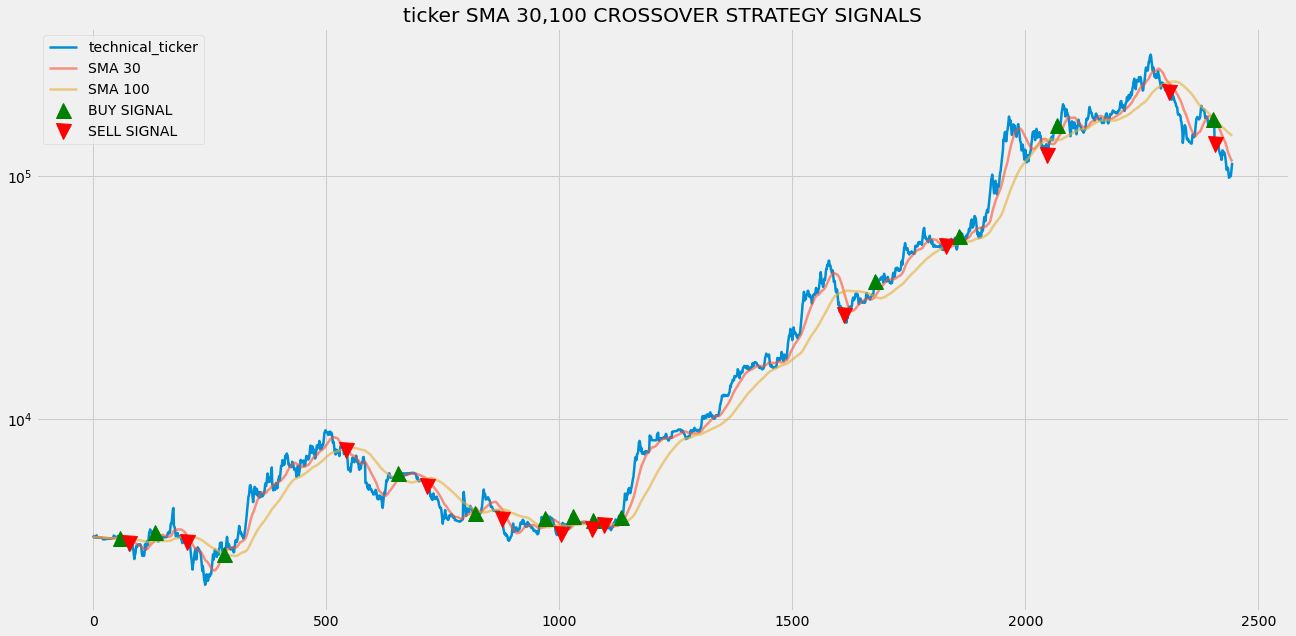

In [147]:
stock_id = '13235547361447092'
adjusted_ticker= getAdjusted_tradeData_ticker(stock_id)
technical_ticker = StockDataFrame(adjusted_ticker)


n_small= 30
n_large=100


technical_ticker.sort_values('date', ascending=True, inplace=True)
buy_signals = technical_ticker[f'close_{n_large}_sma_xd_close_{n_small}_sma']
sell_signals = technical_ticker[f'close_{n_small}_sma_xd_close_{n_large}_sma']
for i in range(len(buy_signals)):
    if buy_signals.iloc[i] == True:
        buy_signals.iloc[i] = technical_ticker.close[i]
    else:
        buy_signals.iloc[i] = np.nan
for i in range(len(sell_signals)):
    if sell_signals.iloc[i] == True:
        sell_signals.iloc[i] = technical_ticker.close[i]
    else:
        sell_signals.iloc[i] = np.nan
        
plt.plot(technical_ticker['close'], linewidth = 2.5, label = 'technical_ticker')
plt.plot(technical_ticker[f'close_{n_small}_sma'], linewidth = 2.5, alpha = 0.6, label = f'SMA {n_small}')
plt.plot(technical_ticker[f'close_{n_large}_sma'], linewidth = 2.5, alpha = 0.6, label = f'SMA {n_large}')
plt.plot(technical_ticker.index, buy_signals, marker = '^', markersize = 15, 
         color = 'green', linewidth = 0, label = 'BUY SIGNAL')

plt.plot(technical_ticker.index, sell_signals, marker = 'v', markersize = 15,
         color = 'r', linewidth = 0, label = 'SELL SIGNAL')

plt.legend(loc = 'upper left')
plt.title(f'ticker SMA {n_small},{n_large} CROSSOVER STRATEGY SIGNALS')
plt.yscale('log',base=10) 
plt.show()

